In [10]:
import torch
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").to(device=DEVICE)
predictor = SamPredictor(sam)

image_bgr = cv2.imread("photos/human.png")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)

box = {'x': 50, 'y': 50, 'width': 250, 'height': 250, 'label': ''}
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

masks, scores, logits = predictor.predict(box=box, multimask_output=True)

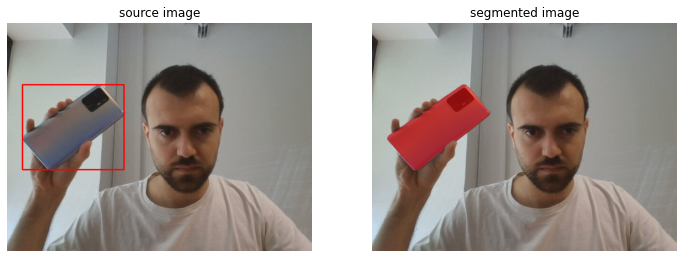

In [11]:
import supervision as sv

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks),mask=masks)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


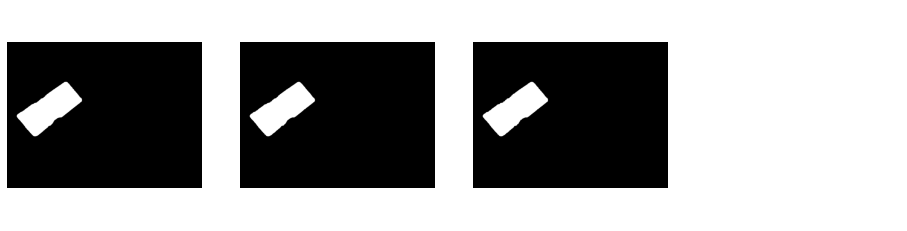

In [12]:
sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

In [16]:
masks[1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [21]:
import imageio
# Apply the mask to the image
segmented_image = image_bgr.copy()
segmented_image[~masks[1]] = 0

# Save the segmented image (replace 'output_path' with the path you want to save the image)
imageio.imwrite('segmented_image.png', segmented_image)

In [24]:
segmented_image= cv2.imread("segmented_image.png")

box = {'x': 50, 'y': 50, 'width': 250, 'height': 250, 'label': ''}

# Calculate the coordinates of the bottom right corner of the box
x2 = box['x'] + box['width']
y2 = box['y'] + box['height']

# Cut the image using the box coordinates
cut_image = segmented_image[box['y']:y2, box['x']:x2]

# Save the cut image (replace 'output_path' with the path you want to save the image)
imageio.imwrite('final_image.png', cut_image)